In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
from typing import Dict, Tuple, List, Optional
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_dir = 'data/WESAD/'

subjects = []

for subject in os.listdir(data_dir):
    if subject.startswith('S'):
        subjects.append(subject)

# subjects = sorted(subjects)
print(subjects)


['S5', 'S2', 'S3', 'S4', 'S17', 'S10', 'S11', 'S16', 'S8', 'S6', 'S7', 'S9', 'S13', 'S14', 'S15']


Available subjects: ['S5', 'S2', 'S3', 'S4', 'S17', 'S10', 'S11', 'S16', 'S8', 'S6', 'S7', 'S9', 'S13', 'S14', 'S15']

Analyzing subject: S5
=== Subject S5 Data Information ===
Data keys: ['signal', 'label', 'subject']

signal (dict):
  chest: <class 'dict'> - {'ACC': array([[ 0.86059999,  0.07420003,  0.85699999],
       [ 0.84560001,  0.07799995,  0.85739994],
       [ 0.84099996,  0.08739996,  0.75699997],
       ...,
       [ 0.90960002, -0.05620003, -0.12940001],
       [ 0.9102    , -0.05580002, -0.13260001],
       [ 0.91059995, -0.05680001, -0.13739997]], shape=(4380600, 3)), 'ECG': array([[-0.27580261],
       [-0.22975159],
       [-0.19528198],
       ...,
       [ 0.01487732],
       [ 0.0292511 ],
       [ 0.03886414]], shape=(4380600, 1)), 'EMG': array([[ 0.01679993],
       [ 0.01496887],
       [ 0.01533508],
       ...,
       [-0.01368713],
       [-0.00100708],
       [ 0.003479  ]], shape=(4380600, 1)), 'EDA': array([[ 3.88832092],
       [ 3.91311646],
       [ 3.8

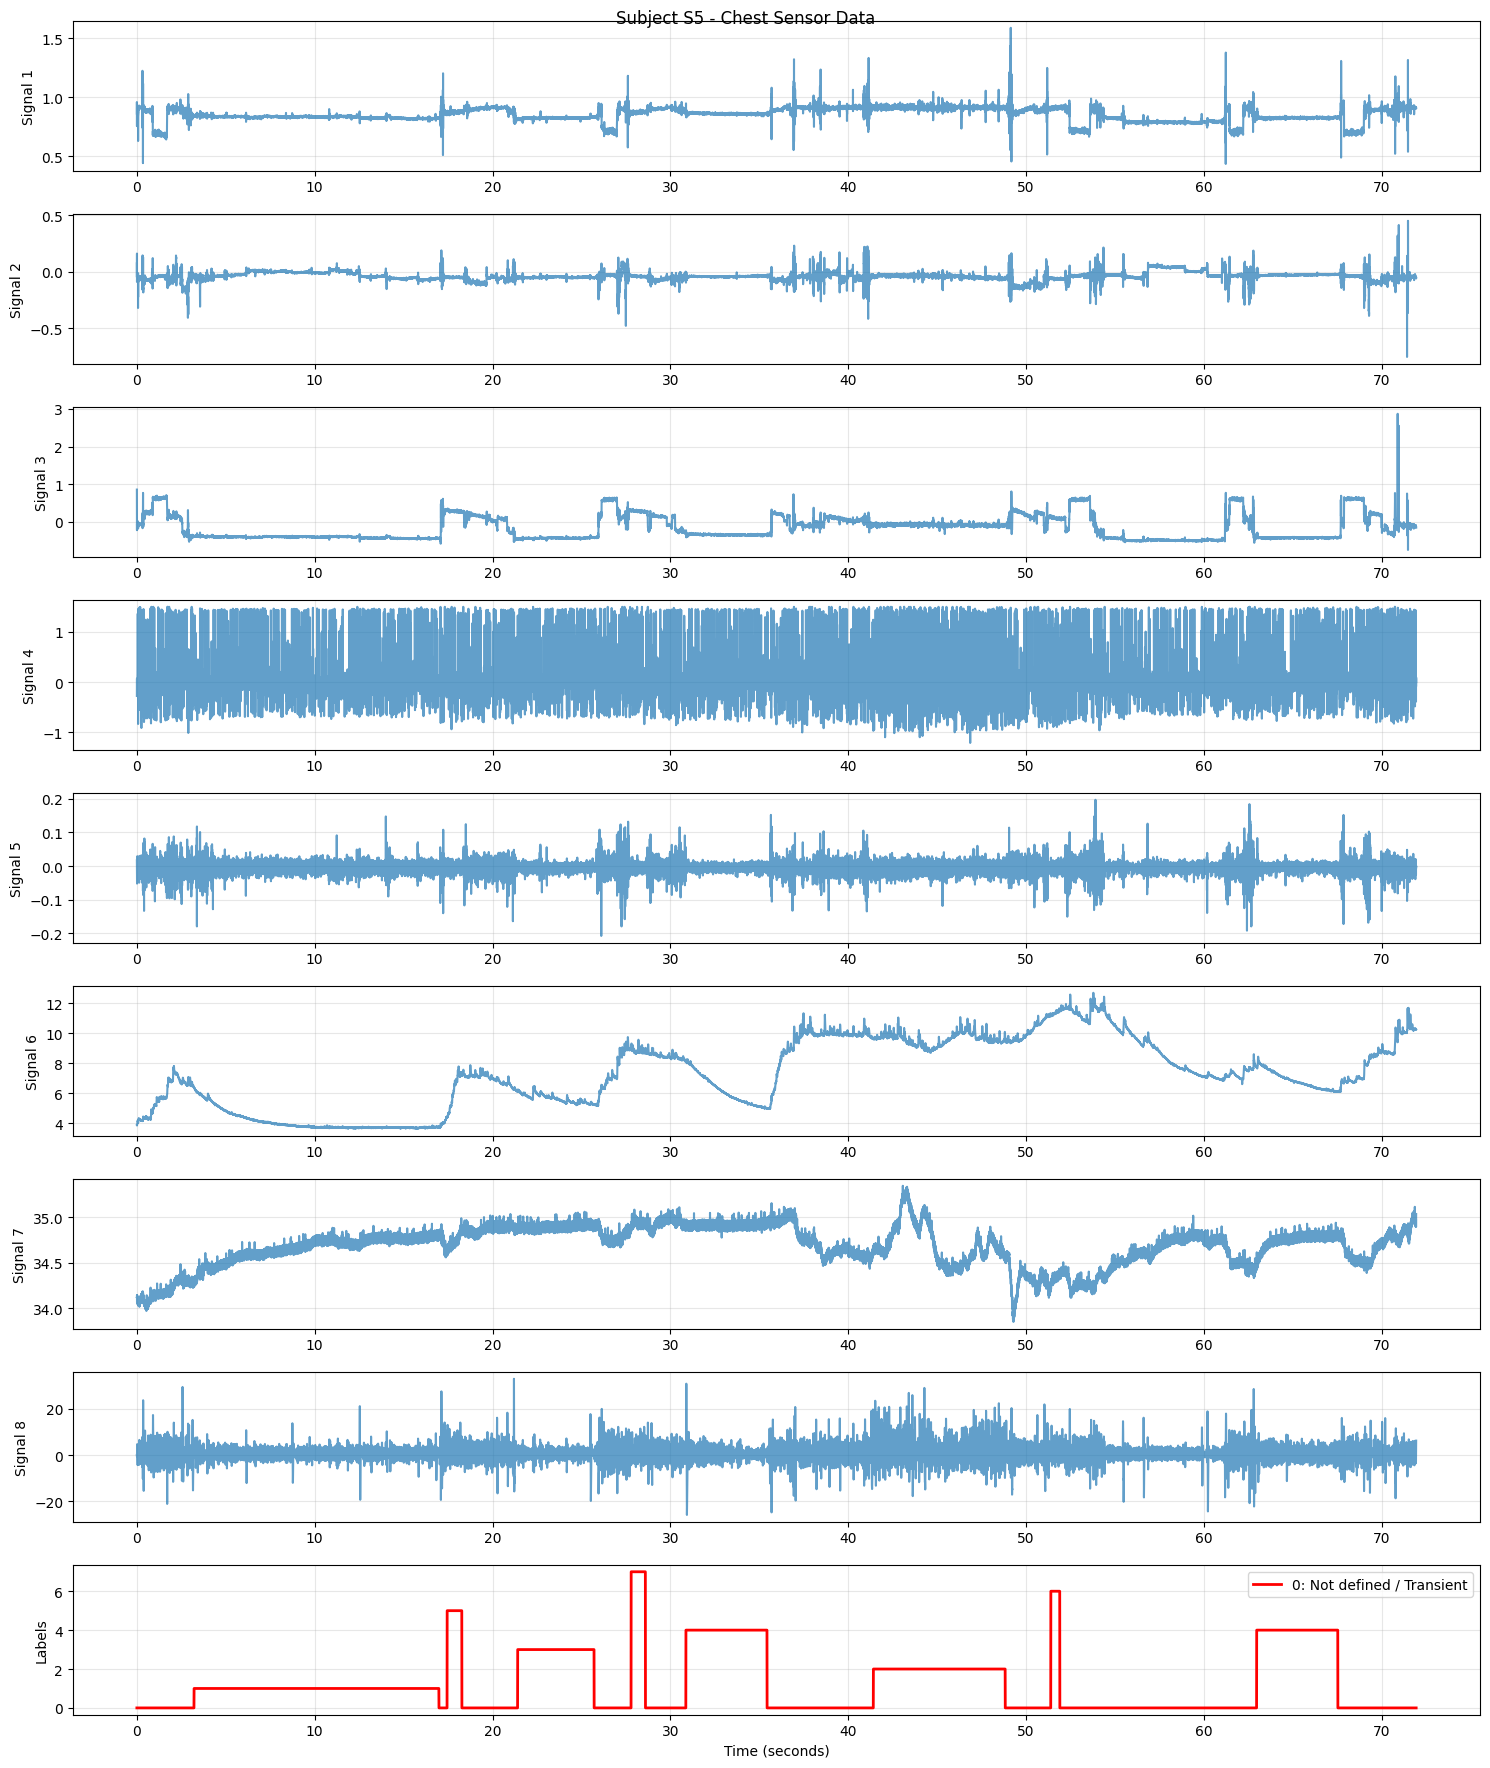


Comparing stress vs baseline for S5...


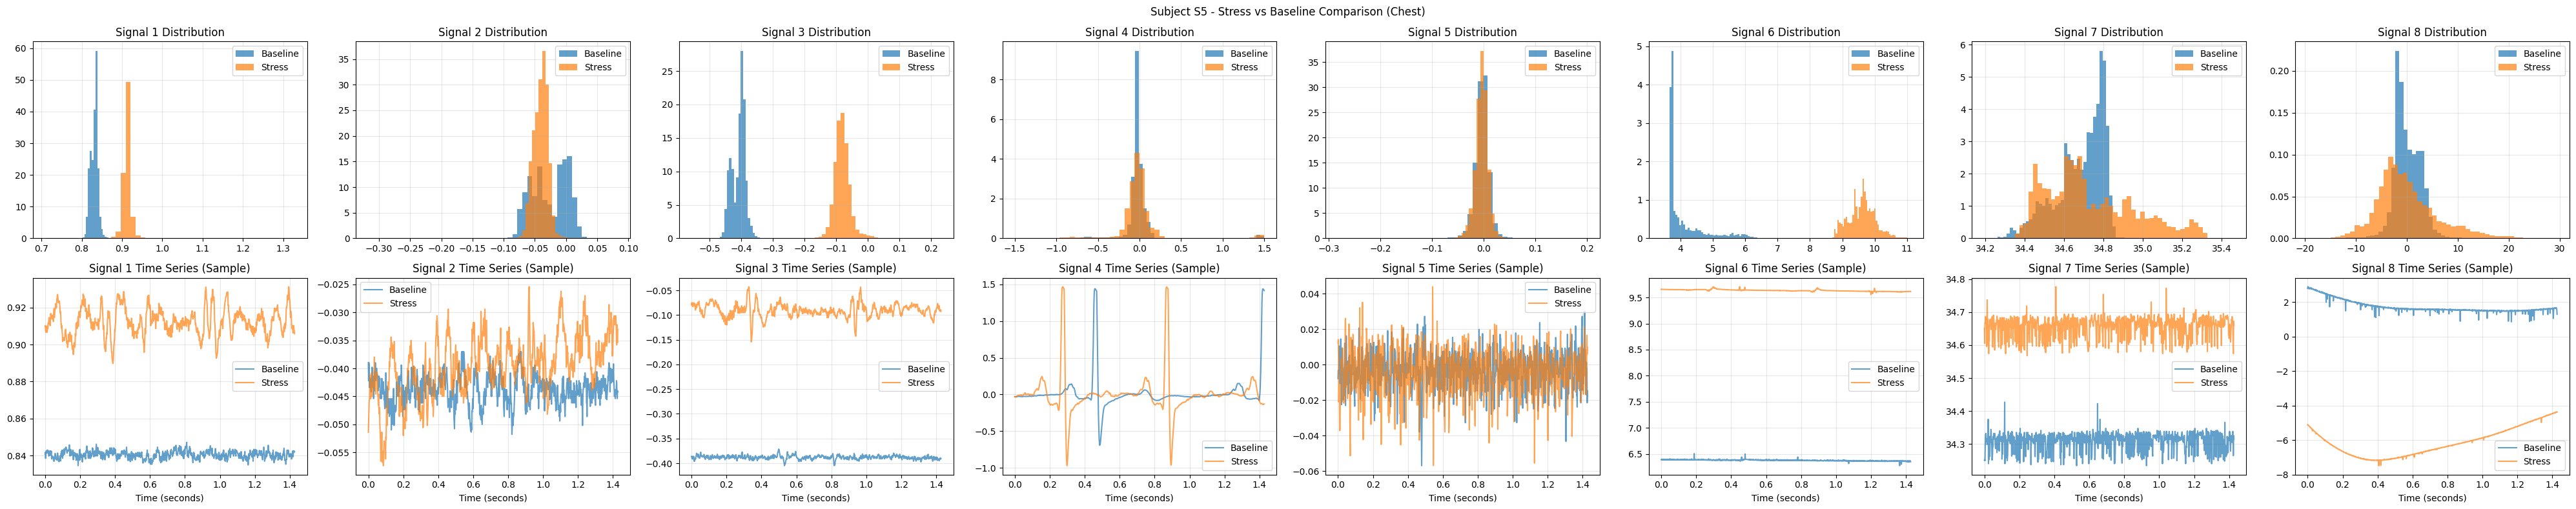

In [2]:
class WESADAnalyzer:
    """
    WESAD (Wearable Stress and Affect Detection) Data Analyzer
    
    This class provides comprehensive analysis tools for the WESAD dataset,
    including data loading, preprocessing, visualization, and stress detection.
    """
    
    def __init__(self, data_dir: str = "data/WESAD"):
        self.data_dir = data_dir
        self.subjects = self._get_available_subjects()
        self.label_mapping = {
            0: 'Not defined / Transient',
            1: 'Baseline',
            2: 'Stress',
            3: 'Amusement',
            4: 'Meditation',
            5: 'Meditation',  # Some datasets have 5 as meditation too
            6: 'Meditation',  # Some datasets have 6 as meditation too
            7: 'Meditation'   # Some datasets have 7 as meditation too
        }
        
    def _get_available_subjects(self) -> List[str]:
        """Get list of available subject IDs"""
        subjects = []
        if os.path.exists(self.data_dir):
            for item in os.listdir(self.data_dir):
                if item.startswith('S') and os.path.isdir(os.path.join(self.data_dir, item)):
                    subjects.append(item)
        return subjects #sorted(subjects)
    
    def load_subject_data(self, subject_id: str) -> Dict:
        """
        Load data for a specific subject
        
        Args:
            subject_id: Subject ID (e.g., 'S2', 'S3', etc.)
            
        Returns:
            Dictionary containing the loaded data
        """
        pkl_path = os.path.join(self.data_dir, subject_id, f"{subject_id}.pkl")
        
        if not os.path.exists(pkl_path):
            raise FileNotFoundError(f"Data file not found: {pkl_path}")
            
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f, encoding='latin1')
            
        return data
    
    def get_data_info(self, subject_id: str) -> None:
        """Print information about the data structure for a subject"""
        data = self.load_subject_data(subject_id)
        
        print(f"=== Subject {subject_id} Data Information ===")
        print(f"Data keys: {list(data.keys())}")
        
        for key, value in data.items():
            if isinstance(value, dict):
                print(f"\n{key} (dict):")
                for subkey, subvalue in value.items():
                    if hasattr(subvalue, 'shape'):
                        print(f"  {subkey}: shape {subvalue.shape}, dtype {subvalue.dtype}")
                    else:
                        print(f"  {subkey}: {type(subvalue)} - {subvalue}")
            elif hasattr(value, 'shape'):
                print(f"{key}: shape {value.shape}, dtype {value.dtype}")
            else:
                print(f"{key}: {type(value)} - {value}")
    
    def extract_chest_data(self, subject_id: str) -> Tuple[np.ndarray, np.ndarray]:
        """
        Extract chest sensor data and labels
        
        Args:
            subject_id: Subject ID
            
        Returns:
            Tuple of (signals, labels)
        """
        data = self.load_subject_data(subject_id)
        
        # Extract chest sensor data - combine all chest sensors
        chest_dict = data['signal']['chest']
        labels = data['label']
        
        # Combine all chest sensor signals into one array
        chest_signals = []
        for sensor_name, sensor_data in chest_dict.items():
            if len(sensor_data.shape) == 1:
                chest_signals.append(sensor_data.reshape(-1, 1))
            else:
                chest_signals.append(sensor_data)
        
        # Concatenate all signals horizontally
        combined_signals = np.concatenate(chest_signals, axis=1)
        
        return combined_signals, labels
    
    def extract_wrist_data(self, subject_id: str) -> Tuple[np.ndarray, np.ndarray]:
        """
        Extract wrist sensor data (E4) and labels
        
        Args:
            subject_id: Subject ID
            
        Returns:
            Tuple of (signals, labels) - Note: wrist sensors may have different sampling rates
        """
        data = self.load_subject_data(subject_id)
        
        # Extract wrist sensor data - combine all wrist sensors
        wrist_dict = data['signal']['wrist']
        labels = data['label']
        
        # Find the sensor with the most samples (usually ACC at 32Hz)
        max_samples = 0
        reference_sensor = None
        for sensor_name, sensor_data in wrist_dict.items():
            if len(sensor_data) > max_samples:
                max_samples = len(sensor_data)
                reference_sensor = sensor_name
        
        # Use the reference sensor length and resample others if needed
        wrist_signals = []
        for sensor_name, sensor_data in wrist_dict.items():
            if len(sensor_data.shape) == 1:
                sensor_data = sensor_data.reshape(-1, 1)
            
            # Simple resampling if lengths don't match
            if len(sensor_data) != max_samples:
                # Linear interpolation to match reference length
                old_indices = np.linspace(0, len(sensor_data)-1, len(sensor_data))
                new_indices = np.linspace(0, len(sensor_data)-1, max_samples)
                resampled = np.zeros((max_samples, sensor_data.shape[1]))
                for col in range(sensor_data.shape[1]):
                    resampled[:, col] = np.interp(new_indices, old_indices, sensor_data[:, col])
                wrist_signals.append(resampled)
            else:
                wrist_signals.append(sensor_data)
        
        # Concatenate all signals horizontally
        combined_signals = np.concatenate(wrist_signals, axis=1)
        
        # Resample labels to match wrist data length (wrist is typically lower sampling rate)
        if len(labels) != len(combined_signals):
            label_indices = np.linspace(0, len(labels)-1, len(combined_signals)).astype(int)
            resampled_labels = labels[label_indices]
        else:
            resampled_labels = labels
        
        return combined_signals, resampled_labels
    
    def plot_signal_overview(self, subject_id: str, sensor_type: str = 'chest', 
                           max_samples: int = 50000) -> None:
        """
        Plot overview of signals with labels
        
        Args:
            subject_id: Subject ID
            sensor_type: 'chest' or 'wrist'
            max_samples: Maximum number of samples to plot (for performance)
        """
        if sensor_type == 'chest':
            signals, labels = self.extract_chest_data(subject_id)
        else:
            signals, labels = self.extract_wrist_data(subject_id)
        
        # Subsample for plotting if data is too large
        if len(signals) > max_samples:
            step = len(signals) // max_samples
            signals = signals[::step]
            labels = labels[::step]
        
        # Create time axis
        time = np.arange(len(signals)) / 700  # Assuming 700 Hz sampling rate
        
        # Plot signals
        n_signals = signals.shape[1] if len(signals.shape) > 1 else 1
        fig, axes = plt.subplots(n_signals + 1, 1, figsize=(15, 2 * (n_signals + 1)))
        
        if n_signals == 1:
            axes = [axes]
        
        # Plot each signal
        for i in range(n_signals):
            if len(signals.shape) > 1:
                signal = signals[:, i]
            else:
                signal = signals
            
            axes[i].plot(time, signal, alpha=0.7)
            axes[i].set_ylabel(f'Signal {i+1}')
            axes[i].grid(True, alpha=0.3)
        
        # Plot labels
        axes[-1].plot(time, labels, 'r-', linewidth=2)
        axes[-1].set_ylabel('Labels')
        axes[-1].set_xlabel('Time (seconds)')
        axes[-1].grid(True, alpha=0.3)
        
        # Add label legend
        unique_labels = sorted(set(labels))
        label_text = [f"{label}: {self.label_mapping.get(label, 'Unknown')}" 
                     for label in unique_labels]
        axes[-1].legend(label_text, loc='upper right')
        
        plt.suptitle(f'Subject {subject_id} - {sensor_type.title()} Sensor Data')
        plt.tight_layout()
        plt.show()
    
    def analyze_labels(self, subject_id: str) -> pd.DataFrame:
        """
        Analyze label distribution for a subject
        
        Args:
            subject_id: Subject ID
            
        Returns:
            DataFrame with label statistics
        """
        data = self.load_subject_data(subject_id)
        labels = data['label']
        
        # Count labels
        label_counts = Counter(labels)
        
        # Create analysis dataframe
        analysis = []
        total_samples = len(labels)
        
        for label, count in sorted(label_counts.items()):
            percentage = (count / total_samples) * 100
            duration_seconds = count / 700  # Assuming 700 Hz
            
            analysis.append({
                'Label': label,
                'Description': self.label_mapping.get(label, 'Unknown'),
                'Count': count,
                'Percentage': f"{percentage:.2f}%",
                'Duration (min)': f"{duration_seconds/60:.2f}"
            })
        
        return pd.DataFrame(analysis)
    
    def extract_stress_baseline_data(self, subject_id: str, sensor_type: str = 'chest') -> Dict:
        """
        Extract stress and baseline periods for analysis
        
        Args:
            subject_id: Subject ID
            sensor_type: 'chest' or 'wrist'
            
        Returns:
            Dictionary with stress and baseline data
        """
        if sensor_type == 'chest':
            signals, labels = self.extract_chest_data(subject_id)
        else:
            signals, labels = self.extract_wrist_data(subject_id)
        
        # Extract stress (label 2) and baseline (label 1) periods
        stress_mask = labels == 2
        baseline_mask = labels == 1
        
        result = {
            'stress_signals': signals[stress_mask],
            'baseline_signals': signals[baseline_mask],
            'stress_labels': labels[stress_mask],
            'baseline_labels': labels[baseline_mask]
        }
        
        return result
    
    def plot_stress_vs_baseline(self, subject_id: str, sensor_type: str = 'chest') -> None:
        """
        Compare stress vs baseline signals
        
        Args:
            subject_id: Subject ID
            sensor_type: 'chest' or 'wrist'
        """
        data = self.extract_stress_baseline_data(subject_id, sensor_type)
        
        stress_signals = data['stress_signals']
        baseline_signals = data['baseline_signals']
        
        if len(stress_signals) == 0 or len(baseline_signals) == 0:
            print(f"No stress or baseline data found for subject {subject_id}")
            return
        
        # Calculate statistics
        n_signals = stress_signals.shape[1] if len(stress_signals.shape) > 1 else 1
        
        fig, axes = plt.subplots(2, n_signals, figsize=(5 * n_signals, 8))
        if n_signals == 1:
            axes = axes.reshape(-1, 1)
        
        for i in range(n_signals):
            if len(stress_signals.shape) > 1:
                stress_sig = stress_signals[:, i]
                baseline_sig = baseline_signals[:, i]
            else:
                stress_sig = stress_signals
                baseline_sig = baseline_signals
            
            # Plot distributions
            axes[0, i].hist(baseline_sig, bins=50, alpha=0.7, label='Baseline', density=True)
            axes[0, i].hist(stress_sig, bins=50, alpha=0.7, label='Stress', density=True)
            axes[0, i].set_title(f'Signal {i+1} Distribution')
            axes[0, i].legend()
            axes[0, i].grid(True, alpha=0.3)
            
            # Plot time series samples
            sample_size = min(1000, len(stress_sig), len(baseline_sig))
            time_stress = np.arange(sample_size) / 700
            time_baseline = np.arange(sample_size) / 700
            
            axes[1, i].plot(time_baseline, baseline_sig[:sample_size], 
                           label='Baseline', alpha=0.7)
            axes[1, i].plot(time_stress, stress_sig[:sample_size], 
                           label='Stress', alpha=0.7)
            axes[1, i].set_title(f'Signal {i+1} Time Series (Sample)')
            axes[1, i].set_xlabel('Time (seconds)')
            axes[1, i].legend()
            axes[1, i].grid(True, alpha=0.3)
        
        plt.suptitle(f'Subject {subject_id} - Stress vs Baseline Comparison ({sensor_type.title()})')
        plt.tight_layout()
        plt.show()
    
    def get_summary_statistics(self, subject_id: str) -> Dict:
        """
        Get comprehensive summary statistics for a subject
        
        Args:
            subject_id: Subject ID
            
        Returns:
            Dictionary with summary statistics
        """
        data = self.load_subject_data(subject_id)
        
        # Count chest sensors
        chest_sensor_count = 0
        for sensor_name, sensor_data in data['signal']['chest'].items():
            if len(sensor_data.shape) > 1:
                chest_sensor_count += sensor_data.shape[1]
            else:
                chest_sensor_count += 1
        
        # Count wrist sensors
        wrist_sensor_count = 0
        for sensor_name, sensor_data in data['signal']['wrist'].items():
            if len(sensor_data.shape) > 1:
                wrist_sensor_count += sensor_data.shape[1]
            else:
                wrist_sensor_count += 1
        
        summary = {
            'subject_id': subject_id,
            'total_duration_minutes': len(data['label']) / 700 / 60,  # Assuming 700 Hz
            'sampling_rate_hz': 700,  # WESAD standard for chest
            'chest_sensors': chest_sensor_count,
            'wrist_sensors': wrist_sensor_count,
            'chest_sensor_types': list(data['signal']['chest'].keys()),
            'wrist_sensor_types': list(data['signal']['wrist'].keys()),
            'label_distribution': dict(Counter(data['label']))
        }
        
        return summary

# Example usage and analysis functions
def main():
    """Main function demonstrating WESAD analysis"""
    
    # Initialize analyzer
    analyzer = WESADAnalyzer()
    
    print("Available subjects:", analyzer.subjects)
    
    if not analyzer.subjects:
        print("No WESAD data found. Please check your data directory.")
        return
    
    # Analyze first available subject
    subject = analyzer.subjects[0]
    print(f"\nAnalyzing subject: {subject}")
    
    # Get data information
    analyzer.get_data_info(subject)
    
    # Analyze labels
    print(f"\n=== Label Analysis for {subject} ===")
    label_analysis = analyzer.analyze_labels(subject)
    print(label_analysis)
    
    # Get summary statistics
    print(f"\n=== Summary Statistics for {subject} ===")
    summary = analyzer.get_summary_statistics(subject)
    for key, value in summary.items():
        print(f"{key}: {value}")
    
    # Plot signal overview
    print(f"\nPlotting signal overview for {subject}...")
    analyzer.plot_signal_overview(subject, sensor_type='chest')
    
    # Compare stress vs baseline
    print(f"\nComparing stress vs baseline for {subject}...")
    analyzer.plot_stress_vs_baseline(subject, sensor_type='chest')

if __name__ == "__main__":
    main() 